In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
 
%matplotlib inline

In [ ]:
print(torch.__version__)

1.9.0+cu102


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
os.listdir("/content/drive/MyDrive/Lung/Normal")

['Images']

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 5
STATS = (.5, .5, .5), (.5, .5, .5)
DATA_DIR = '/content/drive/MyDrive/Lung/Normal'

In [ ]:

train_ds = ImageFolder(DATA_DIR, transform= T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize((.5, .5, .5), (.5, .5, .5))
]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [ ]:
img, _ = next(iter(train_dl))
img.shape

torch.Size([5, 3, 64, 64])

In [ ]:
def denorm(img_tensor):
    return img_tensor * STATS[1][0] + STATS[0][0]

In [ ]:
def showImages(images):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach())).permute(1, 2, 0))

def showBatch(dl):
    for images, _ in dl:
        showImages(images)
        break

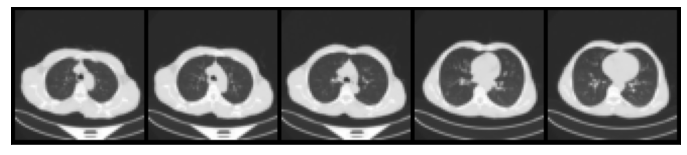

In [ ]:
for i, (real_images, _) in enumerate(train_dl):
  if i==3:
    showImages(real_images)
    break

In [ ]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    
    
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1,  kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
noise = torch.randn(BATCH_SIZE, 3, 1, 1)
print(noise.shape)
noise = to_device(noise,device)

torch.Size([5, 3, 1, 1])


In [ ]:
generator  = nn.Sequential(
  
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(3, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
cgenerator  = nn.Sequential(
  
    
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(3, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
generator = to_device(generator, device)

torch.Size([5, 3, 64, 64])


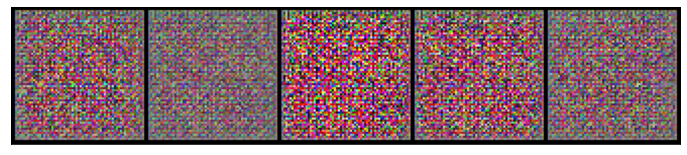

In [ ]:
fake_image = generator(noise)
print(fake_image.shape)
showImages(fake_image)

In [ ]:
import torch.optim as optim

In [ ]:
def train_discriminator(real_image, gen_input, opt_d):
  opt_d.zero_grad()

  #Pass real Image through discriminator
  real_preds = discriminator(real_image)
  real_targets = torch.ones(real_image.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #Generate fake images from noise latent space
  fake_images = generator(gen_input)

  #Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward(retain_graph=True)
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(gen_input, opt_g):
  opt_g.zero_grad()

  #Generate fake images from noise latent space
  fake_images = generator(gen_input)

  #Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(gen_input.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #Update generator weights
  loss.backward(retain_graph=True)
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
save_dir = '/content/drive/MyDrive/LungG/Generated/Images'
os.makedirs(save_dir, exist_ok = True)

In [ ]:
def save_sample(index, gen_input, show=True):
    fake_images = generator(gen_input)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(save_dir, fake_fname))
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


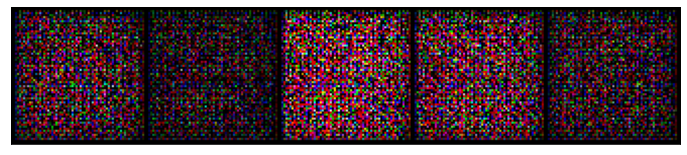

In [ ]:
save_sample(0, noise)

In [ ]:
import torch.nn.functional as F

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    #Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        
        for i, (real_images, _) in tqdm(enumerate(train_dl)):
            # Train discriminator 
            noise = torch.randn(5, 3, 1, 1)
            noise = to_device(noise,device)
            loss_d, real_score, fake_score = train_discriminator(real_image=real_images, gen_input=noise , opt_d=opt_d)
            loss_g = train_generator(gen_input=noise, opt_g=opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save Generated images
        save_sample(epoch+start_idx, noise, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

NameError: ignored

In [ ]:
noise = torch.randn(5, 3, 1, 1)
noise = to_device(noise,device)
fake_image = generator(noise)
print(fake_image.shape)
showImages(fake_image)

NameError: ignored

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
len(losses_g), len(losses_g), len(real_scores), len(fake_scores)

(5, 5, 5, 5)

In [ ]:
model_dir = '/content/drive/MyDrive/LungData/Model'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
losses_g = np.array(losses_g)
np.save(os.path.join(model_dir, 'losses_g.npy'), losses_g)

In [ ]:
losses_d = np.array(losses_d)
np.save(os.path.join(model_dir, 'losses_d.npy'), losses_d)

real_scores = np.array(real_scores)
np.save(os.path.join(model_dir,'real_scores.npy'), real_scores)

fake_scores = np.array(fake_scores)
np.save(os.path.join(model_dir, 'fake_scores.npy'), fake_scores)

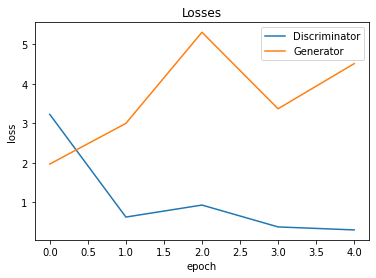

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.savefig(os.path.join(model_dir, 'losses.png'))

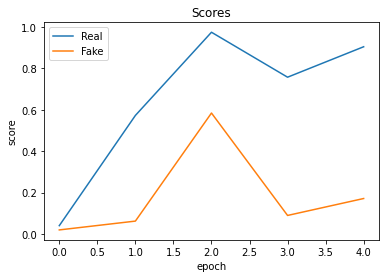

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.savefig(os.path.join(model_dir, 'scores.png'))

In [ ]:
class CGeneratorModel(nn.Module):
  
  def __init__(self):
    super(CGeneratorModel, self).__init__()
    input_dim = 3 + 1
    output_dim = 512
    self.label_embedding = nn.Sequential(
                nn.Embedding(3, 3),
	              nn.Linear(3, 16)
               )
    
    self.hidden_layer1 = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(3, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    )
    self.hidden_layer2 = nn.Sequential(
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    )
    self.hidden_layer3 = nn.Sequential(
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    )
    self.hidden_layer4 = nn.Sequential(
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    )
    self.output_layer = nn.Sequential(
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    )
    
  def forward(self, x,labels):

    output = self.hidden_layer1(x)
    output = self.hidden_layer2(output)
    output = self.hidden_layer3(output)
    output = self.hidden_layer4(output)
    output = self.output_layer(output)
    output = to_device(output,device)
    return output

In [ ]:
class CDiscriminatorModel(nn.Module):
  
  def __init__(self):
    super(CDiscriminatorModel, self).__init__()
    self.label_embedding = nn.Sequential(
        nn.Embedding(3, 3),
	      nn.Linear(3, 3*128*128)
    )
    self.hidden_layer1 = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3+1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    )
    self.hidden_layer2 = nn.Sequential(
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16
    )
    self.hidden_layer3 = nn.Sequential(
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    )
    self.hidden_layer4 = nn.Sequential(
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    )
    self.output_layer = nn.Sequential(
    nn.Conv2d(512, 1,  kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
    )
    
  def forward(self, x,labels):
    label_output = self.label_embedding(labels)
    label_output = label_output.view(-1, 3, 64, 64)
    x = torch.cat((x, label_output), dim=1)
    output = self.hidden_layer1(x)
    output = self.hidden_layer2(output)
    output = self.hidden_layer3(output)
    output = self.hidden_layer4(output)
    output = self.output_layer(output)
    output = to_device(output,device)
    return output

In [ ]:
cdiscriminator = CDiscriminatorModel()
cgenerator = CGeneratorModel()
cdiscriminator = to_device(cdiscriminator,device)
cgenerator = to_device(cgenerator,device)

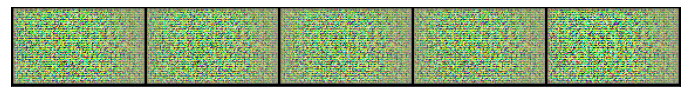

In [ ]:
fake_labels =  torch.full((BATCH_SIZE,3,1,), 1)
fake_labels = to_device(fake_labels,device)
#print(fake_labels.shape)
noise = torch.randn(BATCH_SIZE, 3, 1, 1)
noise = to_device(noise,device)
#print(noise.shape)
generated_data = cgenerator(noise, fake_labels)
showImages(generated_data)

In [ ]:
def train_cdiscriminator(real_image, gen_input,fake_labels, opt_d):
  opt_d.zero_grad()

  #Pass real Image through discriminator
  real_preds = cdiscriminator(real_image,fake_labels)
  real_targets = torch.ones(real_image.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  #Generate fake images from noise latent space
  fake_images = cgenerator(gen_input,fake_labels)

  #Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = cdiscriminator(fake_images,fake_labels)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward(retain_graph=True)
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_cgenerator(gen_input, fake_labels,opt_g):
  opt_g.zero_grad()

  #Generate fake images from noise latent space
  fake_images = cgenerator(gen_input,fake_labels)

  #Try to fool the discriminator
  preds = cdiscriminator(fake_images,fake_labels)
  targets = torch.ones(gen_input.size(0), 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #Update generator weights
  loss.backward(retain_graph=True)
  opt_g.step()

  return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    #Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(cdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(cgenerator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        fake_labels =  torch.full((BATCH_SIZE,3,1,), 1)
        fake_labels = to_device(fake_labels,device)
        for i, (real_images, labels) in tqdm(enumerate(train_dl)):
            # Train discriminator 
            noise = torch.randn(5, 3, 1, 1)
            noise = to_device(noise,device)
            labels = to_device(labels,device)
            loss_d, real_score, fake_score = train_cdiscriminator(real_image=real_images,fake_labels=labels, gen_input=noise , opt_d=opt_d)
            loss_g = train_cgenerator(gen_input=noise,fake_labels=labels, opt_g=opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save Generated images
        #save_sample(epoch+start_idx, noise, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 5

In [ ]:

history = fit(epochs, lr)

0it [00:00, ?it/s]

torch.Size([5, 3])
torch.Size([5, 3, 1, 1])


RuntimeError: ignored

In [ ]:
embedding = nn.Embedding(64, 64)
# a batch of 2 samples of 4 indices each
input = (torch.ones((1,64))*1).to(torch.long)

input.shape
embedding(input).shape

torch.Size([1, 64, 64])

In [ ]:
for i, (real_images, labels) in tqdm(enumerate(train_dl)):
  print(labels)
  

0it [00:00, ?it/s]

tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0])


KeyboardInterrupt: ignored

NameError: ignored

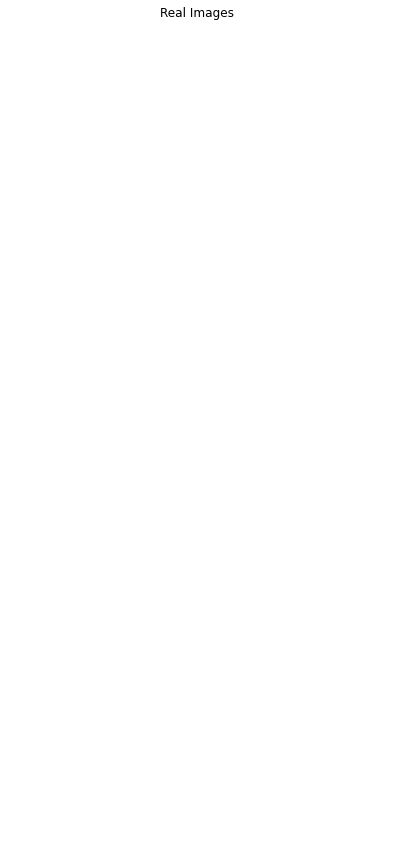

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# # Plot the fake images from the last epoch
# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
# plt.show()

SRGAN

In [ ]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_act=True,
        use_bn=True,
        **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x


In [ ]:
class SR_Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2), UpsampleBlock(num_channels, 2))
        # self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)
        self.final = nn.Conv2d(num_channels, 3, kernel_size=9, stride=1, padding=4)


    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return torch.tanh(self.final(x))

In [ ]:

class SR_Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [ ]:
import math


class SRGenerator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(SRGenerator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class SRDiscriminator(nn.Module):
    def __init__(self):
        super(SRDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 3, kernel_size=1)
        )

    def forward(self, x):
        #x = x.view(x.size(0), -1)
        batch = x.size(0)
        return torch.sigmoid(self.net(x).view(batch))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [ ]:
srgenerator = SR_Generator()
srdiscriminator = SR_Discriminator()
srdiscriminator = to_device(srdiscriminator, device)
srgenerator = to_device(srgenerator, device)

torch.Size([5, 1])


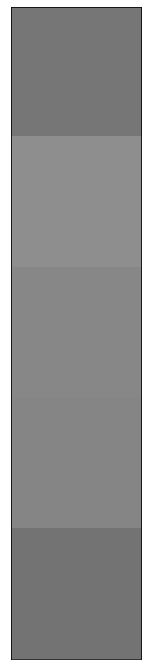

In [ ]:
noise = torch.randn(5, 3, 64, 64)
noise = to_device(noise,device)
fake_image = srgenerator(noise)

fake_image = srdiscriminator(noise)
print(fake_image.shape)
showImages(fake_image)

# C GAN

In [ ]:
from torchvision.models import vgg19


class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval()
        self.vgg = to_device(self.vgg,device)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)


In [ ]:

torch.backends.cudnn.benchmark = True


def train_fn(disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):

    for idx, (real_image, _) in enumerate(train_dl):
        high_res = to_device(real_image,device)
        low_res =  to_device(torch.randn(5, 3, 64, 64),device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = srgenerator(low_res)
        p = T.Compose([T.Scale((64,64))])
        disc_real = srdiscriminator(high_res)
        disc_fake = srdiscriminator(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        )
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward(retain_graph=True)

        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = srdiscriminator(fake)
        #l2_loss = mse(fake, high_res)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss
        #print("Gen loss"+str(gen_loss))
        opt_gen.zero_grad()
        gen_loss.backward(retain_graph=True)
        opt_gen.step()

        # if idx % 200 == 0:
        #     plot_examples("test_images/", gen)
    return (gen_loss,loss_disc)



In [ ]:

gen = srgenerator
disc = srdiscriminator
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = VGGLoss()

for epoch in range(30):
  metadatum = train_fn(disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
  print('Epoch'+str(epoch))
  print(metadatum)
  #save_sample2(epoch+0, latent_vectors_batched[i], show=False)
  


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([5, 512, 4, 4])) that is different to the input size (torch.Size([5, 512, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
 x = torch.randn((5, 3, low_resolution, low_resolution))
        gen = Generator()
        gen_out = gen(x)
        disc = Discriminator()
        disc_out = disc(gen_out)

        print(gen_out.shape)
        print(disc_out.shape)

torch.Size([5, 3, 64, 64])


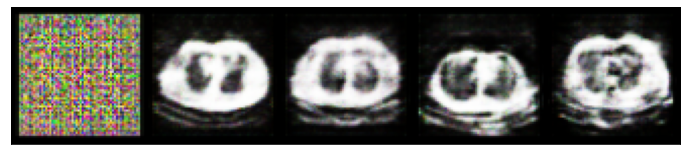

In [ ]:
for idx, (real_image, _) in enumerate(train_dl):
  print(real_image.shape)
  showImages(real_image)
  break

In [ ]:
"""
Implementation of ProGAN generator and discriminator with the key
attributions from the paper. We have tried to make the implementation
compact but a goal is also to keep it readable and understandable.
Specifically the key points implemented are:
1) Progressive growing (of model and layers)
2) Minibatch std on Discriminator
3) Normalization with PixelNorm
4) Equalized Learning Rate (here I cheated and only did it on Conv layers)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

"""
Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.
    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class ProGenerator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class ProDiscriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)



TypeError: ignored

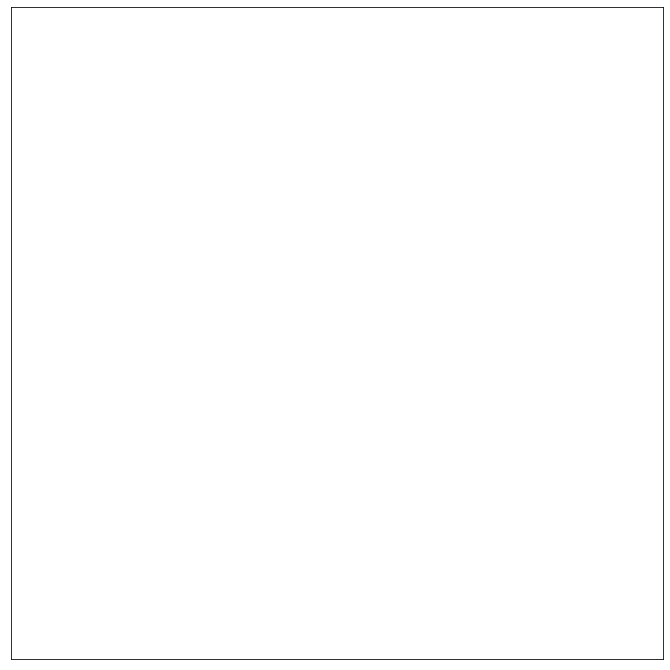

In [ ]:
Z_DIM = 100
IN_CHANNELS = 256
gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)

for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
  num_steps = int(log2(img_size / 4))
  x = torch.randn((1, Z_DIM, 1, 1))
  z = gen(x, 0.5, steps=num_steps)
  assert z.shape == (1, 3, img_size, img_size)
  out = critic(z, alpha=0.5, steps=num_steps)
  assert out.shape == (1, 1)
  print(f"Success! At img size: {img_size}")

In [ ]:
""" Training of ProGAN using WGAN-GP loss"""

import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils import (
    gradient_penalty,
    plot_to_tensorboard,
    save_checkpoint,
    load_checkpoint,
    generate_examples,
)
from model import Discriminator, Generator
from math import log2
from tqdm import tqdm
import config

torch.backends.cudnn.benchmarks = True


def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(config.CHANNELS_IMG)],
                [0.5 for _ in range(config.CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=config.DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (config.PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha


def main():
    # initialize gen and disc, note: discriminator should be called critic,
    # according to WGAN paper (since it no longer outputs between [0, 1])
    # but really who cares..
    gen = Generator(
        config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
    ).to(config.DEVICE)
    critic = Discriminator(
        config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
    ).to(config.DEVICE)

    # initialize optimizers and scalers for FP16 training
    opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(
        critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99)
    )
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    # for tensorboard plotting
    writer = SummaryWriter(f"logs/gan1")

    if config.LOAD_MODEL:
        load_checkpoint(
            config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
        )
        load_checkpoint(
            config.CHECKPOINT_CRITIC, critic, opt_critic, config.LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))
    for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
            )

            if config.SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=config.CHECKPOINT_CRITIC)

        step += 1  # progress to the next img size


In [ ]:
import torch
import random
import numpy as np
import os
import torchvision
import torch.nn as nn
import config
from torchvision.utils import save_image
from scipy.stats import truncnorm

# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, steps, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)), device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

ModuleNotFoundError: ignored

In [ ]:
import cv2
import torch
from math import log2

START_TRAIN_AT_IMG_SIZE = 128
DATASET = 'celeb_dataset'
CHECKPOINT_GEN = "generator.pth"
CHECKPOINT_CRITIC = "critic.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_MODEL = True
LOAD_MODEL = False
LEARNING_RATE = 1e-3
BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
CHANNELS_IMG = 3
Z_DIM = 256  # should be 512 in original paper
IN_CHANNELS = 256  # should be 512 in original paper
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4

In [ ]:
!pip install torchgan

     |████████████████████████████████| 70 kB 3.7 MB/s 


In [ ]:
import torchgan

In [ ]:
import torchgan.models as models

In [ ]:
D = models.InfoGANDiscriminator(10, 30)
x = torch.randn(10, 3, 32, 32)
score, q_categorical, q_gaussian = D(x, return_latents=True)

In [ ]:
G = models.InfoGANGenerator(10, 30)
z = torch.randn(10, 100)
c_cont = torch.randn(10, 10)
c_dis = torch.randn(10, 30)
x = G(z, c_cont, c_dis)

In [ ]:
torch.ones(5,3,64,64)

NameError: ignored